# **Tuning and Design of the network**

## **Preliminary definitions**

In [ ]:
# Import necessary libraries
import os
import warnings
import logging
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
from PIL import Image
import matplotlib.gridspec as gridspec
import json
import keras_cv
from tqdm import tqdm

In [ ]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [ ]:
# Setting che correct strategy for TPU
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.INFO:tensorflow:Initializing the TPU system: local

INFO:tensorflow:Finished initializing TPU system.INFO:tensorflow:Found TPU system:INFO:tensorflow:*** Num TPU Cores: 8INFO:tensorflow:*** Num TPU Workers: 1INFO:tensorflow:*** Num TPU Cores Per Worker: 8INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)INFO:tensorfl

In [ ]:
# The batch size is set to 256 due to the number of samples we have
batch_size = 256
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 32

print(f"Batch size: {batch_size}")

Batch size: 256

## **Data preparation**

In [ ]:
data_path = "/kaggle/input/blood-cells/cleaned_training_set.npz"

In [ ]:
data = np.load(data_path, allow_pickle=True)
lst = data.files
X = data[lst[0]]
y = data[lst[1]]

# Convert values in data to int
X = X.astype(int)

# Normalize data to the range [0, 1]
X = (X / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y = tf.keras.utils.to_categorical(y)

# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.15, stratify=y)

del X, y

# Print the shapes of the loaded datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (10165, 96, 96, 3)Training Label Shape: (10165, 8)Validation Data Shape: (1794, 96, 96, 3)Validation Label Shape: (1794, 8)

In [ ]:
# Use tf.data.Dataset to speedup training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(10240).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache().shuffle(2048).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

# Steps per epoch necessary since train_dataset is infinite
steps_per_epoch = y_train.shape[0] // batch_size

print("Input Shape: ", input_shape)
print("Output Shape: ", output_shape)
print("Steps per epoch: ", steps_per_epoch)

Input Shape:  (96, 96, 3)Output Shape:  8Steps per epoch:  39

## **Custom callback and helping functions**

In [ ]:
# Custom callback class for real-time plotting
class RealTimePlot(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['categorical_accuracy'])
        self.val_acc.append(logs['val_categorical_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [ ]:
class DisplayLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the current learning rate from the optimizer and display it
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1} : Learning rate = {tf.keras.backend.get_value(lr)}")

## **Network design**

In [ ]:
@register_keras_serializable()
class CustomCastLayer(tfk.layers.Layer):
    def call(self, inputs):
        return tf.cast(inputs * 255, tf.uint8)

In [ ]:
def create_model(shape=input_shape, n_labels=output_shape, convnext_trainable=False,  # standard definitions
                 n_dense_layers=1, initial_dense_neurons=1024, min_neurons=64,  # architecture definitions
                 include_dropout=False, dropout_rate=0.3, l2_lambda=0,  # against overfitting
                 optimizer=tfk.optimizers.Adam(),
                 loss=tfk.losses.CategoricalCrossentropy()
                ):

    # Seed for reproducibility
    tf.random.set_seed(42)

    # The input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    # The cast augmentation layers
    x = CustomCastLayer()(inputs)

    # The convnext layer with include_top=False to take the convolutional part only
    convnext = tfk.applications.ConvNeXtXLarge(
                input_shape=input_shape,
                weights='imagenet',
                include_top=False
            )

    # Here we freeze the convnext to perform Transfer Learning
    convnext.trainable = convnext_trainable

    x = convnext(inputs)
    x = tfkl.GlobalAveragePooling2D()(x)

    # Hidden layers building
    neurons = initial_dense_neurons
    for k in range(n_dense_layers):
        x = tfkl.Dense(units=neurons, activation='silu', name=f'Dense_layer_{k}', kernel_regularizer=tfk.regularizers.L2(l2_lambda))(x)
        if include_dropout:
            x = tfkl.Dropout(dropout_rate, name=f'Dropout_layer_{k}')(x)
        neurons = max(neurons // 2, min_neurons)

    outputs = tfkl.Dense(output_shape, activation='softmax', name='output_layer')(x)

    # Final model building
    model = tfk.Model(inputs=inputs, outputs=outputs, name='TF-CNN')

    # Compile the model
    loss = loss
    METRICS = [tfk.metrics.CategoricalAccuracy()]
    optimizer = optimizer

    model.compile(loss=loss, optimizer=optimizer, metrics=METRICS)

    # Return the model
    return model

In [ ]:
def train_models(configs, dataset, results, evs,
                 steps_per_epoch=steps_per_epoch, batch_size=batch_size):

    """
    This function trains and evaluates diffenrent models according to a specific configuration.
    """

    train_data, val_data = dataset

    optimizer_map = {
        'Adam': tfk.optimizers.Adam,
        'AdamW': tfk.optimizers.AdamW,
        'Lion': tfk.optimizers.Lion
    }


    # Define loss
    loss_map = {
        'CategoricalCrossentropy': tfk.losses.CategoricalCrossentropy(),
        'CategoricalFocalCrossentropy': tfk.losses.CategoricalFocalCrossentropy(
                                                alpha=0.25,
                                                gamma=2.0,
                                                from_logits=False,
                                                label_smoothing=0.0,
                                                axis=-1,
                                                reduction="sum_over_batch_size",
                                                name="categorical_focal_crossentropy",
                                                dtype=None,
                                            )
    }



    for config in configs:
        print(f"Training with configuration: {config}")

        optimizer = optimizer_map[config['optimizer']](learning_rate=config['learning_rate'])
        loss = loss_map[config['loss']]

        # Create model with the current configuration
        model = create_model(
            n_dense_layers=config['n_dense_layers'],
            include_dropout=config['include_dropout'],
            dropout_rate=config['dropout_rate'],
            optimizer=optimizer,
            loss=loss
        )

        # Train the model
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=100,
            batch_size=batch_size,
            steps_per_epoch=steps_per_epoch,
            verbose=1
        )

        # Save history
        result = {
                'config': config,
                'history': history.history
            }

        evaluation = model.evaluate(val_dataset)
        print(f"Config {config} scores are {evaluation}")

        evaluations.append({'config': config, 'evaluation': evaluation})

        results.append(result)

        print(f"Finished training {config['name']}")
        del model

    return results

In [ ]:
# The configurations to be compared
configs = [
    {
        'name': 'HiddenLayer = 1',
        'n_dense_layers': 1,
        'include_dropout': False,
        'dropout_rate': 0,
        'learning_rate': 1e-3,
        'optimizer': 'Adam',
        'loss': 'CategoricalCrossentropy'
    },
    {
        'name': 'HiddenLayer = 2',
        'n_dense_layers': 2,
        'include_dropout': False,
        'dropout_rate': 0,
        'learning_rate': 1e-3,
        'optimizer': 'Adam',
        'loss': 'CategoricalCrossentropy'
    },
    {
        'name': 'HiddenLayer = 3',
        'n_dense_layers': 3,
        'include_dropout': False,
        'dropout_rate': 0,
        'learning_rate': 1e-3,
        'optimizer': 'Adam',
        'loss': 'CategoricalCrossentropy'
    },
    {
        'name': 'Optimizer = AdamW',
        'n_dense_layers': 2,
        'include_dropout': False,
        'dropout_rate': 0,
        'learning_rate': 1e-3,
        'optimizer': 'AdamW',
        'loss': 'CategoricalCrossentropy'
    },
    {
        'name': 'Optimizer = Lion',
        'n_dense_layers': 2,
        'include_dropout': False,
        'dropout_rate': 0,
        'learning_rate': 1e-4,
        'optimizer': 'Lion',
        'loss': 'CategoricalCrossentropy'
    },
    {
        'name': 'Loss = Focal',
        'n_dense_layers': 2,
        'include_dropout': False,
        'dropout_rate': 0,
        'learning_rate': 1e-3,
        'optimizer': 'Adam',
        'loss': 'CategoricalFocalCrossentropy'
    },
    {
        'name': 'Dropout = 0.35',
        'n_dense_layers': 2,
        'include_dropout': True,
        'dropout_rate': 0.35,
        'learning_rate': 1e-3,
        'optimizer': 'Adam',
        'loss': 'CategoricalCrossentropy'
    },
    {
        'name': 'Dropout = 0.45',
        'n_dense_layers': 2,
        'include_dropout': True,
        'dropout_rate': 0.45,
        'learning_rate': 1e-3,
        'optimizer': 'Adam',
        'loss': 'CategoricalCrossentropy'
    },
    {
        'name': 'LR = 1e-4',
        'n_dense_layers': 2,
        'include_dropout': False,
        'dropout_rate': 0,
        'learning_rate': 1e-4,
        'optimizer': 'Adam',
        'loss': 'CategoricalCrossentropy'
    },
]

In [ ]:
results = []
evaluations = []

with strategy.scope():
    results, evaluations = train_models(configs, (train_dataset, val_dataset), results=results, evs=evaluations)

Training with configuration: {'name': 'HiddenLayer = 1', 'n_dense_layers': 1, 'include_dropout': False, 'dropout_rate': 0, 'learning_rate': 0.001, 'optimizer': 'Adam', 'loss': 'CategoricalCrossentropy'}

I0000 00:00:1731948720.181840      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

2024-11-18 16:53:12.596852: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.I0000 00:00:1731948793.902247     822 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8d7ae55ab07a3fe6:0:0), session_name()

 2/39 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - categorical_accuracy: 0.1094 - loss: 3.1254  

I0000 00:00:1731948801.201057     822 tpu_compile_op_common.cc:245] Compilation of 8d7ae55ab07a3fe6:0:0 with session name  took 7.298748927s and succeededI0000 00:00:1731948801.223068     822 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8d7ae55ab07a3fe6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2679179042909330605", property.function_library_fingerprint = 2565755461515174577, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731948801.223130     822 tpu_compilation_cache_interface.cc:541] After adding entry for key 8d7a

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.3336 - loss: 2.9231

I0000 00:00:1731948803.266255     809 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7fdea22520c34746:0:0), session_name()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - categorical_accuracy: 0.3374 - loss: 2.8970

I0000 00:00:1731948808.708202     809 tpu_compile_op_common.cc:245] Compilation of 7fdea22520c34746:0:0 with session name  took 5.441883301s and succeededI0000 00:00:1731948808.727302     809 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7fdea22520c34746:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2679179042909330605", property.function_library_fingerprint = 2565755461515174577, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "23,96,96,3,;23,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731948808.727343     809 tpu_compilation_cache_interface.cc:541] After adding entry for key 7fde

39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 603ms/step - categorical_accuracy: 0.3410 - loss: 2.8723 - val_categorical_accuracy: 0.6978 - val_loss: 0.8765Epoch 2/100 1/39 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - categorical_accuracy: 0.5312 - loss: 1.1436

I0000 00:00:1731948824.146771     796 tpu_compile_op_common.cc:245] Compilation of 679983984b26cae8:0:0 with session name  took 4.539173003s and succeededI0000 00:00:1731948824.168179     796 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(679983984b26cae8:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17052810086067459090", property.function_library_fingerprint = 11968697104231482459, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731948824.168216     796 tpu_compilation_cache_interface.cc:541] After adding entry for key 6799

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.6784 - loss: 0.9099 - val_categorical_accuracy: 0.7200 - val_loss: 0.7618Epoch 3/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7318 - loss: 0.7874 - val_categorical_accuracy: 0.6889 - val_loss: 0.7770Epoch 4/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7534 - loss: 0.7465 - val_categorical_accuracy: 0.7689 - val_loss: 0.6998Epoch 5/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - categorical_accuracy: 0.7986 - loss: 0.5907 - val_categorical_accuracy: 0.7911 - val_loss: 0.5909Epoch 6/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.8116 - loss: 0.5527 - val_categorical_accuracy: 0.7511 - val_loss: 0.6523Epoch 7/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - categorical_accuracy: 0.8143 - loss: 0.5261 - val_categorical_accuracy: 0.7289 - val_loss: 0.6337Epoch 8/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.8366 - loss: 0.5201 - val_categori

2024-11-18 17:00:19.871268: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.I0000 00:00:1731949221.181579     786 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(97af6f97a09fc656:0:0), session_name()

 2/39 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - categorical_accuracy: 0.2031 - loss: 3.2463  

I0000 00:00:1731949227.373545     786 tpu_compile_op_common.cc:245] Compilation of 97af6f97a09fc656:0:0 with session name  took 6.191920116s and succeededI0000 00:00:1731949227.400414     786 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(97af6f97a09fc656:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2590793909371097093", property.function_library_fingerprint = 10386944113899480321, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731949227.400452     786 tpu_compilation_cache_interface.cc:541] After adding entry for key 97a

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.3590 - loss: 2.4456

I0000 00:00:1731949229.206739     796 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6558a9bdbbe02ef1:0:0), session_name()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - categorical_accuracy: 0.3626 - loss: 2.4247

I0000 00:00:1731949234.970224     796 tpu_compile_op_common.cc:245] Compilation of 6558a9bdbbe02ef1:0:0 with session name  took 5.763437572s and succeededI0000 00:00:1731949234.994617     796 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6558a9bdbbe02ef1:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2590793909371097093", property.function_library_fingerprint = 10386944113899480321, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "23,96,96,3,;23,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731949234.994651     796 tpu_compilation_cache_interface.cc:541] After adding entry for key 655

39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 646ms/step - categorical_accuracy: 0.3661 - loss: 2.4050 - val_categorical_accuracy: 0.6711 - val_loss: 0.9236Epoch 2/100 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - categorical_accuracy: 0.5625 - loss: 1.0625

I0000 00:00:1731949251.951212     812 tpu_compile_op_common.cc:245] Compilation of 2c5c5ef2c8b45652:0:0 with session name  took 4.341600564s and succeededI0000 00:00:1731949251.973601     812 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2c5c5ef2c8b45652:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8178255395004778077", property.function_library_fingerprint = 9279940125887071764, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731949251.973636     812 tpu_compilation_cache_interface.cc:541] After adding entry for key 2c5c5e

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.6836 - loss: 0.8949 - val_categorical_accuracy: 0.7689 - val_loss: 0.6712Epoch 3/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - categorical_accuracy: 0.7770 - loss: 0.6483 - val_categorical_accuracy: 0.8089 - val_loss: 0.5988Epoch 4/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.7855 - loss: 0.6280 - val_categorical_accuracy: 0.7778 - val_loss: 0.6357Epoch 5/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.7950 - loss: 0.5742 - val_categorical_accuracy: 0.7156 - val_loss: 0.6790Epoch 6/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - categorical_accuracy: 0.8180 - loss: 0.5059 - val_categorical_accuracy: 0.7689 - val_loss: 0.6118Epoch 7/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.8313 - loss: 0.4713 - val_categorical_accuracy: 0.8000 - val_loss: 0.6331Epoch 8/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.8121 - loss: 0.5078 - val_categor

2024-11-18 17:07:29.294440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.I0000 00:00:1731949650.627117     787 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e36cb6eed6aac7ad:0:0), session_name()

 2/39 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - categorical_accuracy: 0.1250 - loss: 3.1968  

I0000 00:00:1731949656.880857     787 tpu_compile_op_common.cc:245] Compilation of e36cb6eed6aac7ad:0:0 with session name  took 6.253690472s and succeededI0000 00:00:1731949656.902391     787 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e36cb6eed6aac7ad:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_336772405037628493", property.function_library_fingerprint = 6324591247458987814, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731949656.902434     787 tpu_compilation_cache_interface.cc:541] After adding entry for key e36cb

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.3657 - loss: 2.1114

I0000 00:00:1731949658.777815     830 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ef673451739b5adf:0:0), session_name()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - categorical_accuracy: 0.3695 - loss: 2.0956

I0000 00:00:1731949664.554804     830 tpu_compile_op_common.cc:245] Compilation of ef673451739b5adf:0:0 with session name  took 5.776917622s and succeededI0000 00:00:1731949664.576365     830 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ef673451739b5adf:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_336772405037628493", property.function_library_fingerprint = 6324591247458987814, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "23,96,96,3,;23,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731949664.576426     830 tpu_compilation_cache_interface.cc:541] After adding entry for key ef673

39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 640ms/step - categorical_accuracy: 0.3732 - loss: 2.0807 - val_categorical_accuracy: 0.6133 - val_loss: 0.9972Epoch 2/100 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - categorical_accuracy: 0.7188 - loss: 0.7993

I0000 00:00:1731949681.217300     812 tpu_compile_op_common.cc:245] Compilation of 9df9983c20d7ee33:0:0 with session name  took 4.640528646s and succeededI0000 00:00:1731949681.239063     812 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9df9983c20d7ee33:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6805725519922118637", property.function_library_fingerprint = 10303335674498756317, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731949681.239097     812 tpu_compilation_cache_interface.cc:541] After adding entry for key 9df99

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.6899 - loss: 0.8652 - val_categorical_accuracy: 0.7467 - val_loss: 0.7416Epoch 3/10039/39 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - categorical_accuracy: 0.7492 - loss: 0.6883 - val_categorical_accuracy: 0.7600 - val_loss: 0.6911Epoch 4/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - categorical_accuracy: 0.8034 - loss: 0.5972 - val_categorical_accuracy: 0.7733 - val_loss: 0.5970Epoch 5/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - categorical_accuracy: 0.7879 - loss: 0.5838 - val_categorical_accuracy: 0.8000 - val_loss: 0.5846Epoch 6/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.8272 - loss: 0.4881 - val_categorical_accuracy: 0.8089 - val_loss: 0.4875Epoch 7/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - categorical_accuracy: 0.8281 - loss: 0.4838 - val_categorical_accuracy: 0.7689 - val_loss: 0.5697Epoch 8/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.8131 - loss: 0.5330 - val_categor

2024-11-18 17:14:43.548924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.I0000 00:00:1731950084.852817     765 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f6c76153191e2277:0:0), session_name()

 2/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - categorical_accuracy: 0.0859 - loss: 2.5401  

I0000 00:00:1731950092.319103     765 tpu_compile_op_common.cc:245] Compilation of f6c76153191e2277:0:0 with session name  took 7.466232404s and succeededI0000 00:00:1731950092.345467     765 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f6c76153191e2277:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_76844085668626323", property.function_library_fingerprint = 16543166094718815322, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731950092.345496     765 tpu_compilation_cache_interface.cc:541] After adding entry for key f6c76

37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.3516 - loss: 2.3251

I0000 00:00:1731950094.212343     791 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d0825f6cf716b766:0:0), session_name()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - categorical_accuracy: 0.3597 - loss: 2.2882

I0000 00:00:1731950099.797896     791 tpu_compile_op_common.cc:245] Compilation of d0825f6cf716b766:0:0 with session name  took 5.585432684s and succeededI0000 00:00:1731950099.823551     791 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d0825f6cf716b766:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_76844085668626323", property.function_library_fingerprint = 16543166094718815322, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "23,96,96,3,;23,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731950099.823587     791 tpu_compilation_cache_interface.cc:541] After adding entry for key d0825

39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 617ms/step - categorical_accuracy: 0.3636 - loss: 2.2709 - val_categorical_accuracy: 0.7156 - val_loss: 0.8815Epoch 2/100 2/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - categorical_accuracy: 0.5938 - loss: 0.9537

I0000 00:00:1731950115.798848     796 tpu_compile_op_common.cc:245] Compilation of 90d9b9df58dbdfd1:0:0 with session name  took 4.683018587s and succeededI0000 00:00:1731950115.821264     796 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(90d9b9df58dbdfd1:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14277502501719816418", property.function_library_fingerprint = 196382697001584959, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731950115.821307     796 tpu_compilation_cache_interface.cc:541] After adding entry for key 90d9b9

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.6695 - loss: 0.8706 - val_categorical_accuracy: 0.7289 - val_loss: 0.6938Epoch 3/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - categorical_accuracy: 0.7351 - loss: 0.7452 - val_categorical_accuracy: 0.7511 - val_loss: 0.6984Epoch 4/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.7544 - loss: 0.6571 - val_categorical_accuracy: 0.7689 - val_loss: 0.7201Epoch 5/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.8232 - loss: 0.5471 - val_categorical_accuracy: 0.7778 - val_loss: 0.5782Epoch 6/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.8038 - loss: 0.5248 - val_categorical_accuracy: 0.7422 - val_loss: 0.7010Epoch 7/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - categorical_accuracy: 0.7991 - loss: 0.5474 - val_categorical_accuracy: 0.7778 - val_loss: 0.5614Epoch 8/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - categorical_accuracy: 0.8275 - loss: 0.4778 - val_categori

2024-11-18 17:21:58.890272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.I0000 00:00:1731950520.267579     781 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2bfcdf1d55da84b4:0:0), session_name()

 2/39 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - categorical_accuracy: 0.1250 - loss: 2.0868  

I0000 00:00:1731950526.719827     781 tpu_compile_op_common.cc:245] Compilation of 2bfcdf1d55da84b4:0:0 with session name  took 6.45219095s and succeededI0000 00:00:1731950526.741894     781 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2bfcdf1d55da84b4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14373521433375318046", property.function_library_fingerprint = 6654736380368756115, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731950526.741935     781 tpu_compilation_cache_interface.cc:541] After adding entry for key 2bfc

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.4230 - loss: 1.6022

I0000 00:00:1731950528.594679     819 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b0f10520223d7229:0:0), session_name()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - categorical_accuracy: 0.4255 - loss: 1.5957

I0000 00:00:1731950534.314006     819 tpu_compile_op_common.cc:245] Compilation of b0f10520223d7229:0:0 with session name  took 5.719270197s and succeededI0000 00:00:1731950534.333824     819 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b0f10520223d7229:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14373521433375318046", property.function_library_fingerprint = 6654736380368756115, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "23,96,96,3,;23,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731950534.333861     819 tpu_compilation_cache_interface.cc:541] After adding entry for key b0f

39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 639ms/step - categorical_accuracy: 0.4278 - loss: 1.5894 - val_categorical_accuracy: 0.6533 - val_loss: 0.9743Epoch 2/100 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - categorical_accuracy: 0.5938 - loss: 1.2089

I0000 00:00:1731950551.019194     835 tpu_compile_op_common.cc:245] Compilation of 8f1b161de7b39eaa:0:0 with session name  took 5.023208337s and succeededI0000 00:00:1731950551.041570     835 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8f1b161de7b39eaa:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2523999366877458268", property.function_library_fingerprint = 11809183369597940055, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731950551.041602     835 tpu_compilation_cache_interface.cc:541] After adding entry for key 8f1b1

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - categorical_accuracy: 0.6449 - loss: 1.0028 - val_categorical_accuracy: 0.7511 - val_loss: 0.6900Epoch 3/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - categorical_accuracy: 0.7419 - loss: 0.7299 - val_categorical_accuracy: 0.7867 - val_loss: 0.6720Epoch 4/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7517 - loss: 0.6899 - val_categorical_accuracy: 0.7644 - val_loss: 0.6333Epoch 5/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - categorical_accuracy: 0.7764 - loss: 0.5850 - val_categorical_accuracy: 0.7733 - val_loss: 0.6720Epoch 6/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.8094 - loss: 0.5120 - val_categorical_accuracy: 0.7733 - val_loss: 0.6048Epoch 7/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - categorical_accuracy: 0.8464 - loss: 0.4500 - val_categorical_accuracy: 0.8356 - val_loss: 0.5174Epoch 8/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.8455 - loss: 0.4464 - val_categori

2024-11-18 17:29:09.528270: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.I0000 00:00:1731950950.869160     812 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(24e509221ac9b04e:0:0), session_name()

 3/39 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - categorical_accuracy: 0.1753 - loss: 0.7091 

I0000 00:00:1731950957.111981     812 tpu_compile_op_common.cc:245] Compilation of 24e509221ac9b04e:0:0 with session name  took 6.242756923s and succeededI0000 00:00:1731950957.134514     812 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(24e509221ac9b04e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2598961772812226039", property.function_library_fingerprint = 10448453049604256196, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731950957.134552     812 tpu_compilation_cache_interface.cc:541] After adding entry for key 24e

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.3559 - loss: 0.5514

I0000 00:00:1731950959.012718     799 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d5015e4115be9351:0:0), session_name()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - categorical_accuracy: 0.3594 - loss: 0.5456

I0000 00:00:1731950964.772890     799 tpu_compile_op_common.cc:245] Compilation of d5015e4115be9351:0:0 with session name  took 5.76012399s and succeededI0000 00:00:1731950964.793420     799 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d5015e4115be9351:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2598961772812226039", property.function_library_fingerprint = 10448453049604256196, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "23,96,96,3,;23,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731950964.793450     799 tpu_compilation_cache_interface.cc:541] After adding entry for key d501

39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 667ms/step - categorical_accuracy: 0.3627 - loss: 0.5401 - val_categorical_accuracy: 0.7067 - val_loss: 0.1318Epoch 2/100 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.7812 - loss: 0.0859

I0000 00:00:1731950982.438868     753 tpu_compile_op_common.cc:245] Compilation of a22a7c0433771918:0:0 with session name  took 4.91409713s and succeededI0000 00:00:1731950982.461473     753 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a22a7c0433771918:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_12032332427012878096", property.function_library_fingerprint = 7261506987801295477, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731950982.461504     753 tpu_compilation_cache_interface.cc:541] After adding entry for key a22a7c

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.6814 - loss: 0.1276 - val_categorical_accuracy: 0.7556 - val_loss: 0.0935Epoch 3/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7477 - loss: 0.0927 - val_categorical_accuracy: 0.7822 - val_loss: 0.0715Epoch 4/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7350 - loss: 0.0904 - val_categorical_accuracy: 0.7378 - val_loss: 0.0936Epoch 5/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.8049 - loss: 0.0721 - val_categorical_accuracy: 0.7378 - val_loss: 0.0860Epoch 6/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.8306 - loss: 0.0602 - val_categorical_accuracy: 0.6889 - val_loss: 0.0865Epoch 7/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.8069 - loss: 0.0679 - val_categorical_accuracy: 0.7378 - val_loss: 0.0922Epoch 8/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.8291 - loss: 0.0633 - val_categori

2024-11-18 17:36:23.583460: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.I0000 00:00:1731951384.910721     778 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(99d5a32b291322bd:0:0), session_name()

 2/39 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - categorical_accuracy: 0.2031 - loss: 2.5564  

I0000 00:00:1731951395.305166     778 tpu_compile_op_common.cc:245] Compilation of 99d5a32b291322bd:0:0 with session name  took 10.394393708s and succeededI0000 00:00:1731951395.336826     778 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(99d5a32b291322bd:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_469664399243527287", property.function_library_fingerprint = 17019875572207607109, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731951395.336862     778 tpu_compilation_cache_interface.cc:541] After adding entry for key 99d

37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.3363 - loss: 2.2270

I0000 00:00:1731951397.184833     786 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(17979d918a272714:0:0), session_name()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - categorical_accuracy: 0.3422 - loss: 2.1976

I0000 00:00:1731951405.316664     786 tpu_compile_op_common.cc:245] Compilation of 17979d918a272714:0:0 with session name  took 8.131756305s and succeededI0000 00:00:1731951405.352918     786 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(17979d918a272714:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_469664399243527287", property.function_library_fingerprint = 17019875572207607109, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "23,96,96,3,;23,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731951405.352959     786 tpu_compilation_cache_interface.cc:541] After adding entry for key 1797

39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 685ms/step - categorical_accuracy: 0.3450 - loss: 2.1838 - val_categorical_accuracy: 0.6889 - val_loss: 0.9103Epoch 2/100 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - categorical_accuracy: 0.6250 - loss: 1.0377

I0000 00:00:1731951421.362559     792 tpu_compile_op_common.cc:245] Compilation of 9bfa616f712d5290:0:0 with session name  took 4.624878014s and succeededI0000 00:00:1731951421.385970     792 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9bfa616f712d5290:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16209981375009136476", property.function_library_fingerprint = 3598927226201951011, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731951421.386005     792 tpu_compilation_cache_interface.cc:541] After adding entry for key 9bfa6

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.6401 - loss: 0.9998 - val_categorical_accuracy: 0.6756 - val_loss: 0.9160Epoch 3/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - categorical_accuracy: 0.7012 - loss: 0.8365 - val_categorical_accuracy: 0.7467 - val_loss: 0.6362Epoch 4/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7186 - loss: 0.7387 - val_categorical_accuracy: 0.7422 - val_loss: 0.6575Epoch 5/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.7351 - loss: 0.7052 - val_categorical_accuracy: 0.7644 - val_loss: 0.6653Epoch 6/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - categorical_accuracy: 0.7805 - loss: 0.6266 - val_categorical_accuracy: 0.7778 - val_loss: 0.5844Epoch 7/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7900 - loss: 0.5691 - val_categorical_accuracy: 0.8222 - val_loss: 0.4901Epoch 8/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - categorical_accuracy: 0.7920 - loss: 0.5419 - val_categori

2024-11-18 17:43:44.144418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.I0000 00:00:1731951825.440340     805 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c8a17fa6db14dfed:0:0), session_name()

 2/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - categorical_accuracy: 0.0781 - loss: 2.9536  

I0000 00:00:1731951834.561614     805 tpu_compile_op_common.cc:245] Compilation of c8a17fa6db14dfed:0:0 with session name  took 9.121161081s and succeededI0000 00:00:1731951834.594338     805 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c8a17fa6db14dfed:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6453005699390349413", property.function_library_fingerprint = 9816206195204662122, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731951834.594377     805 tpu_compilation_cache_interface.cc:541] After adding entry for key c8a1

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.2893 - loss: 2.4643

I0000 00:00:1731951836.459100     794 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(45e5b468d3b34d55:0:0), session_name()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - categorical_accuracy: 0.2929 - loss: 2.4469

I0000 00:00:1731951845.273560     794 tpu_compile_op_common.cc:245] Compilation of 45e5b468d3b34d55:0:0 with session name  took 8.814397405s and succeededI0000 00:00:1731951845.312963     794 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(45e5b468d3b34d55:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6453005699390349413", property.function_library_fingerprint = 9816206195204662122, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "23,96,96,3,;23,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731951845.313007     794 tpu_compilation_cache_interface.cc:541] After adding entry for key 45e5

39/39 ━━━━━━━━━━━━━━━━━━━━ 48s 706ms/step - categorical_accuracy: 0.2963 - loss: 2.4304 - val_categorical_accuracy: 0.6667 - val_loss: 0.9369Epoch 2/100 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - categorical_accuracy: 0.6875 - loss: 1.0502

I0000 00:00:1731951861.442900     823 tpu_compile_op_common.cc:245] Compilation of fdb0de2809493bd6:0:0 with session name  took 4.707589211s and succeededI0000 00:00:1731951861.462664     823 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(fdb0de2809493bd6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4525297922020651391", property.function_library_fingerprint = 5480180174380464056, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731951861.462702     823 tpu_compilation_cache_interface.cc:541] After adding entry for key fdb0de

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.6505 - loss: 1.0300 - val_categorical_accuracy: 0.7022 - val_loss: 0.8153Epoch 3/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7082 - loss: 0.8418 - val_categorical_accuracy: 0.7200 - val_loss: 0.6957Epoch 4/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7173 - loss: 0.7810 - val_categorical_accuracy: 0.7600 - val_loss: 0.6656Epoch 5/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - categorical_accuracy: 0.7383 - loss: 0.7224 - val_categorical_accuracy: 0.7289 - val_loss: 0.7023Epoch 6/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.7502 - loss: 0.7133 - val_categorical_accuracy: 0.7556 - val_loss: 0.6989Epoch 7/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7576 - loss: 0.6864 - val_categorical_accuracy: 0.7200 - val_loss: 0.7374Epoch 8/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.7858 - loss: 0.6451 - val_categori

2024-11-18 17:51:01.707200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.I0000 00:00:1731952263.067500     749 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6d9fb29338072703:0:0), session_name()

 2/39 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - categorical_accuracy: 0.0547 - loss: 2.3702  

I0000 00:00:1731952270.730606     749 tpu_compile_op_common.cc:245] Compilation of 6d9fb29338072703:0:0 with session name  took 7.663030868s and succeededI0000 00:00:1731952270.758707     749 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6d9fb29338072703:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8147185147318105019", property.function_library_fingerprint = 1943577487022502548, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731952270.758747     749 tpu_compilation_cache_interface.cc:541] After adding entry for key 6d9f

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.3662 - loss: 1.7702

I0000 00:00:1731952272.629462     778 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a4b068992e75629f:0:0), session_name()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - categorical_accuracy: 0.3693 - loss: 1.7631

I0000 00:00:1731952278.729628     778 tpu_compile_op_common.cc:245] Compilation of a4b068992e75629f:0:0 with session name  took 6.100026113s and succeededI0000 00:00:1731952278.752146     778 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a4b068992e75629f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8147185147318105019", property.function_library_fingerprint = 1943577487022502548, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "23,96,96,3,;23,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731952278.752198     778 tpu_compilation_cache_interface.cc:541] After adding entry for key a4b0

39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 691ms/step - categorical_accuracy: 0.3722 - loss: 1.7564 - val_categorical_accuracy: 0.6489 - val_loss: 1.0710Epoch 2/100 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - categorical_accuracy: 0.7188 - loss: 0.9521

I0000 00:00:1731952296.999775     752 tpu_compile_op_common.cc:245] Compilation of adf277238140b5ad:0:0 with session name  took 4.926130952s and succeededI0000 00:00:1731952297.024853     752 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(adf277238140b5ad:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11241932457476929087", property.function_library_fingerprint = 3747425376076560520, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731952297.024885     752 tpu_compilation_cache_interface.cc:541] After adding entry for key adf27

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - categorical_accuracy: 0.6985 - loss: 0.9632 - val_categorical_accuracy: 0.7556 - val_loss: 0.7162Epoch 3/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - categorical_accuracy: 0.7265 - loss: 0.7799 - val_categorical_accuracy: 0.6756 - val_loss: 0.8126Epoch 4/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.7691 - loss: 0.6807 - val_categorical_accuracy: 0.7733 - val_loss: 0.6231Epoch 5/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7770 - loss: 0.6706 - val_categorical_accuracy: 0.7067 - val_loss: 0.7705Epoch 6/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.7671 - loss: 0.6286 - val_categorical_accuracy: 0.7644 - val_loss: 0.5962Epoch 7/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - categorical_accuracy: 0.7885 - loss: 0.6170 - val_categorical_accuracy: 0.7733 - val_loss: 0.5531Epoch 8/10039/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - categorical_accuracy: 0.8070 - loss: 0.5598 - val_categori

ValueError: too many values to unpack (expected 2)

In [ ]:
# Function to plot the results
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for result in results:
        history = result['history']
        plt.plot(history['val_categorical_accuracy'][70:99], label=f"{result['config']['name']} - Val ACC")

    plt.title('Validation ACC for different configurations')
    plt.xlabel('Epochs')
    plt.ylabel('ACC')
    plt.legend()
    plt.grid(True)
    plt.show()

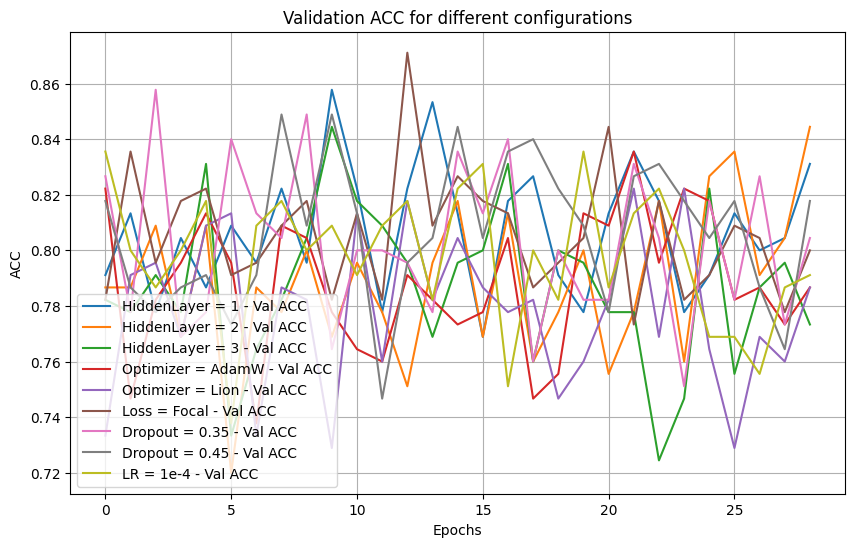

In [ ]:
plot_results(results)

The graph is not very informative since all the models are close to each other.\
Let's use the accuracy score on the val_dataset

In [ ]:
for ev in evaluations:
    print(f"Config {ev['config']['name']} scores {ev['evaluation'][1]}")

Config HiddenLayer = 1 scores 0.7866666913032532Config HiddenLayer = 2 scores 0.800000011920929Config HiddenLayer = 3 scores 0.7733333110809326Config Optimizer = AdamW scores 0.804444432258606Config Optimizer = Lion scores 0.7377777695655823Config Loss = Focal scores 0.8222222328186035Config Dropout = 0.35 scores 0.800000011920929Config Dropout = 0.45 scores 0.7688888907432556Config LR = 1e-4 scores 0.7955555319786072

The number of hidden layers yielding the best accuracy is 2.\
AdamW is better than Lion and can handle a dinamic lr due to its nature\
Focal performs better than standard CategoricalCrossentropy\
Dropout of 0.35 seems the right value for dropout right now.\
Lower lr should perform better. Hence we can reduce a little bit our lr and combine it with our LRReducerOnPlateau too\
This is our starting point for further analysis:

  **Hidden layers = 2**\
  **Optimizer = AdamW**\
  **Loss = CategoricalFocalCrossentropy**\
  **LR = 5e-4**\
  **Dropout = 0.35**

In [ ]:
def final_model(shape=input_shape, n_labels=output_shape, convnext_trainable=False, l2_lambda = 0):

    """
    This function creates the best model according to what we have define previously
    """

    # Seed for reproducibility
    tf.random.set_seed(42)

    # The input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    # The two augmentation layers
    x = CustomCastLayer()(inputs)

    # The convnext layer with include_top=False to take the convolutional part only
    convnext = tfk.applications.ConvNeXtXLarge(
                input_shape=input_shape,
                weights='imagenet',
                include_top=False
            )

    # Here we freeze the convnext to perform Transfer Learning
    convnext.trainable = convnext_trainable

    x = convnext(inputs)
    x = tfkl.GlobalAveragePooling2D()(x)

    # Hidden layers building

    x = tfkl.Dense(units=1024, activation='silu', name='Dense_layer_0', kernel_regularizer=tfk.regularizers.L2(l2_lambda))(x)
    x = tfkl.Dropout(0.35, name='Dropout_layer_0')(x)
    x = tfkl.Dense(units=512, activation='silu', name='Dense_layer_1', kernel_regularizer=tfk.regularizers.L2(l2_lambda))(x)
    x = tfkl.Dropout(0.35, name='Dropout_layer_1')(x)

    outputs = tfkl.Dense(output_shape, activation='softmax', name='output_layer')(x)

    # Final model building
    model = tfk.Model(inputs=inputs, outputs=outputs, name='TF-CNN')

    # Compile the model
    loss = tfk.losses.CategoricalFocalCrossentropy(
                                                alpha=0.25,
                                                gamma=2.0,
                                                from_logits=False,
                                                label_smoothing=0.0,
                                                axis=-1,
                                                reduction="sum_over_batch_size",
                                                name="categorical_focal_crossentropy",
                                                dtype=None,
                                            )
    METRICS = [tfk.metrics.CategoricalAccuracy()]
    optimizer = tfk.optimizers.AdamW(learning_rate=5e-4)

    model.compile(loss=loss, optimizer=optimizer, metrics=METRICS)

    # Return the model
    return model

In [ ]:
with strategy.scope():
    model = final_model()

# Display a summary of the model architecture
model.summary(expand_nested=False, show_trainable=True)

Model: "TF-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │├─────────────────────────────┼───────────────────────┼────────────┼───────┤│ convnext_xlarge             │ (None, 3, 3, 2048)    │ 348,147,9… │   N   ││ (Functional)                │                       │            │       │├─────────────────────────────┼───────────────────────┼────────────┼───────┤│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   ││ (GlobalAveragePooling2D)    │                       │            │       │├─────────────────────────────┼───────────────────────┼────────────┼───────┤│ Dense_layer_0 (Dense)       │ (None, 1024)          │  2,098,176 │   Y   │├─────────────────────────────┼───────────────────────┼────────────┼───────┤│ Dropout_layer_0 (Dropout)   │ (None, 1024)          │          0 │   -   │├─────────────────────────────┼───────────────────────┼────────────┼───────┤│ Dense_layer_1 (Dense)       │ (None, 512)           │    524,800 │   Y   │├─────────────────────────────┼───────────────────────┼────────────┼───────┤│ Dropout_layer_1 (Dropout)   │ (None, 512)           │          0 │   -   │├─────────────────────────────┼───────────────────────┼────────────┼───────┤│ output_layer (Dense)        │ (None, 8)             │      4,104 │   Y   │└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 350,775,048 (1.31 GB)

 Trainable params: 2,627,080 (10.02 MB)

 Non-trainable params: 348,147,968 (1.30 GB)

In [ ]:
# Define the patience value for early stopping
patience = 35

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=patience,
    restore_best_weights=True
)

plot_callback = RealTimePlot()

# Store the callback in a list
callbacks = [early_stopping, plot_callback, DisplayLearningRateCallback()]

Let's fit this model

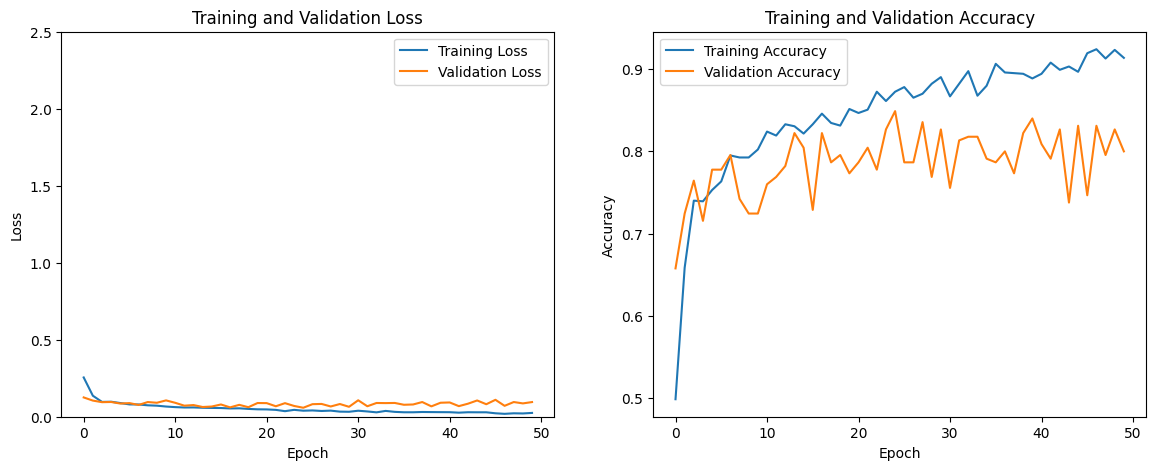

Epoch 50 : Learning rate = 0.000500000023748725739/39 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - categorical_accuracy: 0.9167 - loss: 0.0247 - val_categorical_accuracy: 0.8000 - val_loss: 0.0951

In [ ]:
with strategy.scope():
    history = model.fit(
        train_dataset,
        epochs=120,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        shuffle=True,
        callbacks=callbacks
    ).history

In [ ]:
ev = model.evaluate(val_dataset)
print(f"Val score: {ev[1]}")

2024-11-18 19:13:52.350327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.I0000 00:00:1731957233.082119     801 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(5f105fc79b88a316:0:0), session_name()

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.8203 - loss: 0.0797 

I0000 00:00:1731957238.763989     801 tpu_compile_op_common.cc:245] Compilation of 5f105fc79b88a316:0:0 with session name  took 5.681809787s and succeededI0000 00:00:1731957238.789226     801 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(5f105fc79b88a316:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4210126488265491916", property.function_library_fingerprint = 2860024678457593742, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731957238.789263     801 tpu_compilation_cache_interface.cc:541] After adding entry for key 5f10

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.8033 - loss: 0.0855

I0000 00:00:1731957239.132475     835 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6c2cdeeae3ea83d6:0:0), session_name()

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 682ms/step - categorical_accuracy: 0.7976 - loss: 0.0840Val score: 0.7866666913032532

I0000 00:00:1731957243.570746     835 tpu_compile_op_common.cc:245] Compilation of 6c2cdeeae3ea83d6:0:0 with session name  took 4.438224018s and succeededI0000 00:00:1731957243.588157     835 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6c2cdeeae3ea83d6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4210126488265491916", property.function_library_fingerprint = 2860024678457593742, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")I0000 00:00:1731957243.588186     835 tpu_compilation_cache_interface.cc:541] After adding entry for key 6c2cde

Our val score is worse than previous models.\
We can decide to add more regularization, such as l2.\
Let's say l2 = 1e-3

In [ ]:
with strategy.scope():
    model = final_model(l2_lambda = 1e-3)

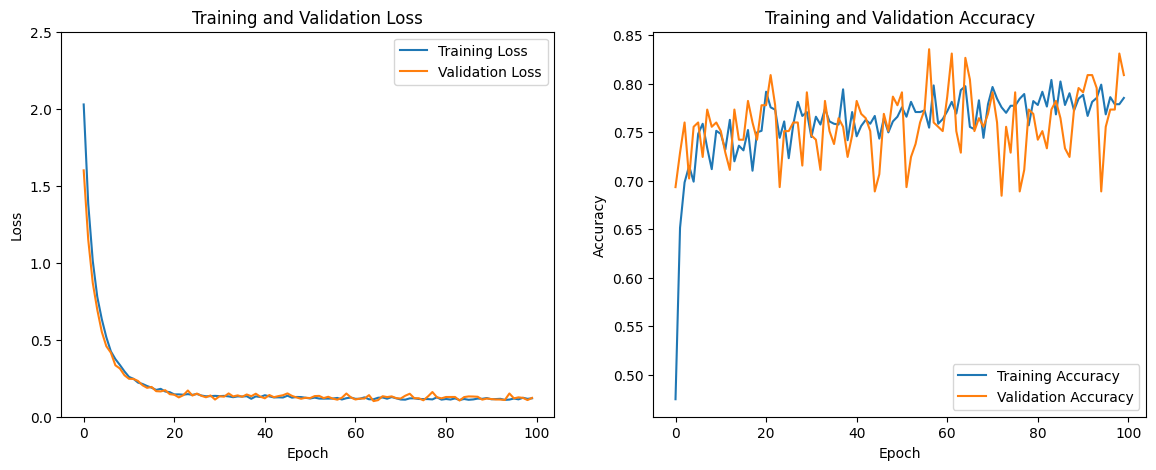

Epoch 100 : Learning rate = 0.000500000023748725739/39 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - categorical_accuracy: 0.7859 - loss: 0.1234 - val_categorical_accuracy: 0.8089 - val_loss: 0.1222

In [ ]:
history = model.fit(
        train_dataset,
        epochs=350,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        shuffle=True,
        callbacks=callbacks
    ).history

In [ ]:
ev = model.evaluate(val_dataset)
print(f"Val score: {ev[1]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - categorical_accuracy: 0.7462 - loss: 0.1221Val score: 0.7644444704055786

In [ ]:
LABELS = [1, 2, 3, 4, 5, 6, 7]
name = 'validation'

In [ ]:
def evaluations(model, ds, y_ds, labels, name):
    # Predict class probabilities and get predicted classes
    ds_predictions = model.predict(ds, verbose=0)
    ds_predictions = np.argmax(ds_predictions, axis=-1)

    # Extract ground truth classes
    ds_gt = np.argmax(y_ds, axis=-1)

    # Calculate and display training set accuracy
    ds_accuracy = accuracy_score(ds_gt, ds_predictions)
    print(f'Accuracy score over the {name} set: {round(ds_accuracy, 4)}')

    # Calculate and display training set precision
    ds_precision = precision_score(ds_gt, ds_predictions, average='weighted')
    print(f'Precision score over the {name} set: {round(ds_precision, 4)}')

    # Calculate and display training set recall
    ds_recall = recall_score(ds_gt, ds_predictions, average='weighted')
    print(f'Recall score over the {name} set: {round(ds_recall, 4)}')

    # Calculate and display training set F1 score
    ds_f1 = f1_score(ds_gt, ds_predictions, average='weighted')
    print(f'F1 score over the {name} set: {round(ds_f1, 4)}')

    # Compute the confusion matrix
    cm = confusion_matrix(ds_gt, ds_predictions)

    # Create labels combining confusion matrix values
    #labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    # Plot the confusion matrix with class labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=cm, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

2024-11-18 19:34:37.910722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node TF-CNN_1/Dense_layer_0_1/Add/ReadVariableOp.I0000 00:00:1731958478.407300     788 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e5a5ce8225826ed3:0:0), session_name()I0000 00:00:1731958483.205015     788 tpu_compile_op_common.cc:245] Compilation of e5a5ce8225826ed3:0:0 with session name  took 4.797671661s and succeededI0000 00:00:1731958483.221565     788 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e5a5ce8225826ed3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_4093159225612281737", property.function_library_fingerprint = 7635299839052894314, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, to

Accuracy score over the validation set: 0.7921Precision score over the validation set: 0.7905Recall score over the validation set: 0.7921F1 score over the validation set: 0.7905

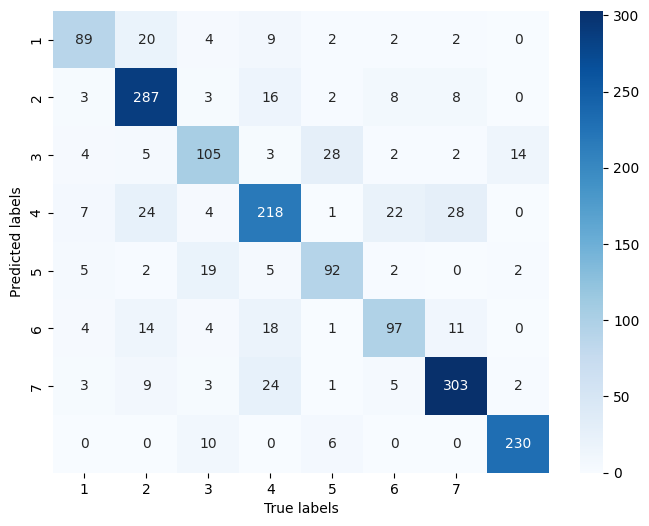

In [ ]:
evaluations(model, X_val, y_val, LABELS, name)

## CONCLUSION

We chose this configuration as the starting point for our model. Without any form of augmentation or Fine-Tuning, we achieved a validation score of 79.21%. Naturally, this configuration may be adjusted later to align with the requirements of augmentation.


**IMPORTANT**\
For augmentation, we initially implemented a very strong augmentation pipeline (refer to the corresponding notebook for details). However, this significantly increased training time. To address this, we ultimately decided to perform augmentation outside the network, allowing faster training on TPUs.\
Since we ran several models locally, we decoupled augmentation from network construction and training. This approach provided deeper insights into how different augmentation strategies impacted model performance, facilitating better hyperparameter tuning.\
By adopting this method, we reduced the total training time for a single model to 4 hours (including both Transfer Learning and Fine-Tuning), or approximately 1m37s per epoch. Initially, training took around 5 minutes per epoch, and the updated setup has resulted in a significant improvement. Note that total training time may still vary due to Early Stopping.

**NOTE**\
The enumeration of cells in this notebook is not perfectly aligned due to the incremental approach taken during its development.

Additionally, many other models were tested but found to be uninformative. We have chosen to retain only the most meaningful ones for this preliminary phase.